In [15]:
import torch
import torch.nn as nn
import timm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from timm.utils import AttentionExtract
from torchvision import transforms
from timm.data import create_transform
from typing import Dict

timm.layers.set_fused_attn(False)

In [120]:
# Load the pre-trained DINOv2 model
model = timm.create_model('vit_small_patch14_dinov2.lvd142m', pretrained=True)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

In [121]:
# Load image from URL
image = Image.open("/content/dog_image_dinov2_short_blog.jpeg")

# Define the transformation
transform = transforms.Compose([
    transforms.Resize(518),
    transforms.CenterCrop(518),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply transformation
img_tensor = transform(image).unsqueeze(0)  # Add batch dimension

In [122]:
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

In [123]:
output = model(transform(image).unsqueeze(0))  # output is (batch_size, num_features) shaped tensor

In [106]:
output = model.forward_features(transforms(img).unsqueeze(0))
# output is unpooled, a (1, 1370, 384) shaped tensor

output = model.forward_head(output, pre_logits=True)

In [125]:
softmax = nn.Softmax(dim=1)
probs = softmax(output)
print(probs.shape)

torch.Size([1, 384])


In [129]:
def process_image(
    image: Image.Image,
    model: torch.nn.Module,
    extractor: AttentionExtract
) -> Dict[str, torch.tensor]:

    """Process the input image and get the attention map"""

    #Get correct transform for the model

    config = model.pretrained_cfg

    transform = create_transform(
        input_size = config['input_size'], #default: (224, 224)
        crop_pct = config['crop_pct'],     #default: no cropping
        mean = config['mean'],
        std = config['std'],
        interpolation = config['interpolation'], #default: bilinear
        is_training = False
    )

    #Preprocess the image
    tensor = transform(image).unsqueeze(0) #add batch

    #Extract the attention maps
    attention_maps = extractor(tensor)

    return attention_maps

In [130]:
extractor = AttentionExtract(model, method='fx') #feature extractor


In [131]:
attention_maps = process_image(image, model, extractor)

print(attention_maps.keys())


dict_keys(['blocks.0.attn.softmax', 'blocks.1.attn.softmax', 'blocks.2.attn.softmax', 'blocks.3.attn.softmax', 'blocks.4.attn.softmax', 'blocks.5.attn.softmax', 'blocks.6.attn.softmax', 'blocks.7.attn.softmax', 'blocks.8.attn.softmax', 'blocks.9.attn.softmax', 'blocks.10.attn.softmax', 'blocks.11.attn.softmax'])


In [132]:
num_prefix_tokens = getattr(model, 'num_prefix_tokens', 1) ## Default to single class token [CLS] if not specified

head_fusion = 'mean'

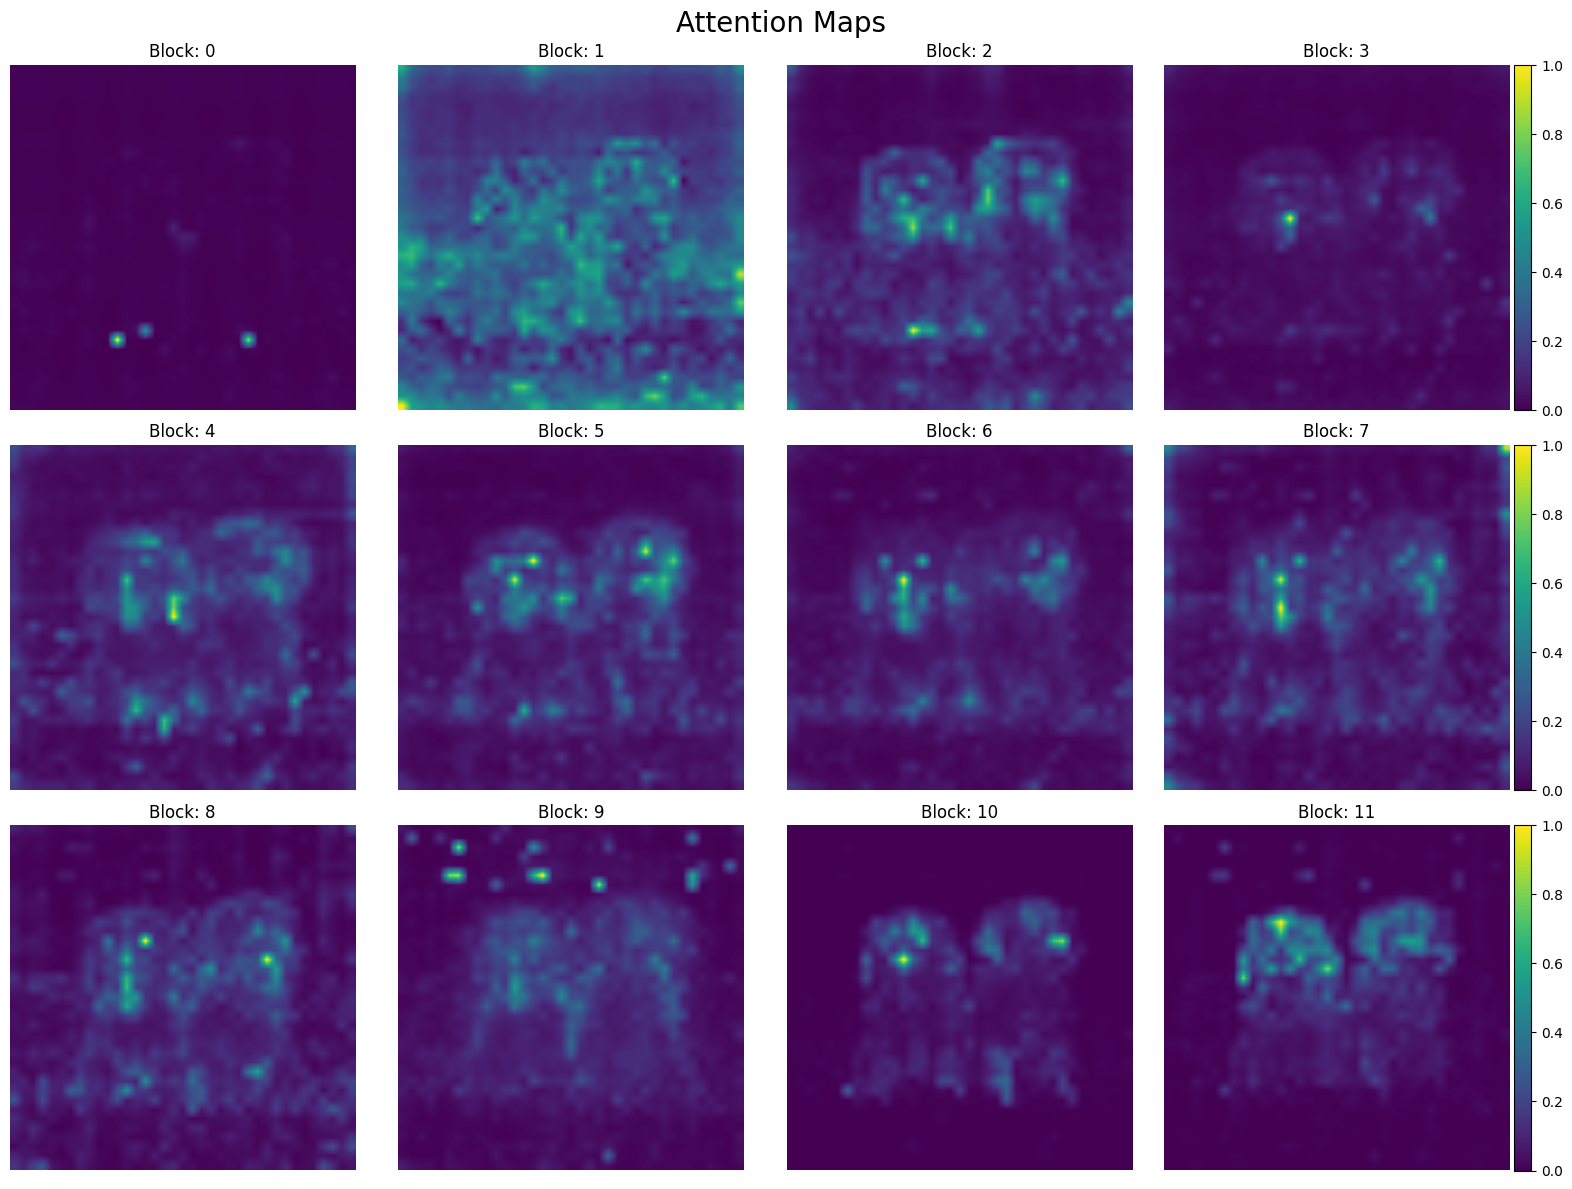

In [134]:
fig, axes = plt.subplots(3, 4, figsize = (16, 12)) #Create a 3x4 grid of subplots
fig.suptitle("Attention Maps", fontsize = (20))
axes = axes.flatten() # Flatten the 2D array of subplots into a 1D array

for i, (layer_name, attn_map) in enumerate(attention_maps.items()):

    attn_map = attn_map[0] #Remove batch dimension; [num_heads, num_patches, num_patches]

    attn_map = attn_map[:, :, num_prefix_tokens:] #Remove prefix tokens [CLS] for visualization

    if head_fusion  == "mean":
        attn_map = attn_map.mean(0) #along the [num_heads, num_patches, num_patches - 1]

    else:
        raise ValueError(f"Invalid head fusion method: {head_fusion}")

    # Use the class token's attention
    attn_map = attn_map[0]

    #Reshape the attention map to 2D
    num_patches = int(attn_map.shape[0] ** 0.5) #to avoid negative values
    attn_map = attn_map.reshape(num_patches, num_patches)

    #Interpolate to match image size
    attn_map = attn_map.unsqueeze(0).unsqueeze(0)

    # Comment the line below, if you like to visualize attention maps without any smoothening effect.
    # which would look similar to the feature image shown in this notebook.
    attn_map = F.interpolate(attn_map, size = (img_tensor.shape[2], img_tensor.shape[2]), mode = 'bilinear', align_corners = False)

    attn_map = attn_map.squeeze().detach().cpu().numpy()

    #Normalize attention map
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

    ax = axes[i]
    im = ax.imshow(attn_map, cmap = 'viridis')
    ax.set_title(f'Block: {i}')
    ax.axis('off')

    #add colorbar only to last subplot
    if (i + 1) % 4 == 0:  # Check if it's the last subplot in a row
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()